### Cross-validation

**output_dir**  
Path to the directory where STAMP will write results, logs, and model checkpoints.

**clini_table**  
Path to an Excel or CSV file containing clinical information for each patient.  
Must include:  
- a patient ID column (named according to `patient_label`),  
- a ground-truth label column (named according to `ground_truth_label`).  
Patients missing in this table are ignored.

**feature_dir**  
Directory containing the extracted feature `.h5` files.

**slide_table**  
Path to an Excel or CSV file mapping each patient to their feature files.  
Must include:  
- a patient ID column (`patient_label`),  
- a filename column (`filename_label`) with paths **relative to `feature_dir`** and including `.h5`.

**task**  
Type of prediction to perform: `"classification"`, `"regression"`, or `"survival"`.

**ground_truth_label**  
Name of the column in `clini_table` containing the target variable to learn.

**status_label** *(survival only)*  
Column indicating event occurrence (1/0). Optional unless task is survival.

**time_label** *(survival only)*  
Column indicating time-to-event or follow-up duration.

**patient_label**  
Column name representing the patient unique identifier. Default is `"PATIENT"`.

**filename_label**  
Column name representing the feature filename relative to `feature_dir`. Default is `"FILENAME"`.

**categories** *(optional)*  
List of class names for classification. If omitted, STAMP infers categories automatically.

**n_splits** *(optional)*  
Number of cross-validation folds.

**params_path** *(optional)*  
Path to an additional YAML file containing advanced training parameters.

**use_vary_precision_transform** *(optional)*  
Whether to apply variable-precision transforms to feature tensors.


In [41]:
crossval_config = {
    "crossval": {
        "output_dir": "/mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1", # change to your desired output directory
        "clini_table": "/mnt/bulk-sirius/nguyenmin/multiplex/Clini_Table_Vorversuche_HER2.xlsx",
        "feature_dir": "/mnt/bulk-sirius/nguyenmin/multiplex/features/her2_feats_patient_level",
        "slide_table": "/mnt/bulk-sirius/nguyenmin/multiplex/slides.csv",
        "task": "classification",
        "ground_truth_label": "Ergebnis mIF HER2",
        "patient_label": "Patho-ID",
        "filename_label": "FILENAME",
        "n_splits": 5,
    },
    "advanced_config": {
        "seed": 42,
        "max_epochs": 64,
        "patience": 8,
        "batch_size": 64,
        # Only for tile-level training. Reducing its amount could affect
        # model performance. Reduces memory consumption. Default value works
        # fine for most cases.
        "bag_size": 512,
        #num_workers: 16 # Default chosen by cpu cores
        # One Cycle Learning Rate Scheduler parameters. Check docs for more info.
        # Determines the initial learning rate via initial_lr = max_lr/div_factor
        "max_lr": 1e-4,
        "div_factor": 25.0 ,
        # Select a model regardless of task
        "model_name": "vit", # or mlp, trans_mil

        "model_params":{
            "vit": {# Vision Transformer
                "dim_model": 512,
                "dim_feedforward": 512,
                "n_heads": 8,
                "n_layers": 2,
                "dropout": 0.25,
            },
            "trans_mil": {# https://arxiv.org/abs/2106.00908
                "dim_hidden": 512,
            },
            "mlp": {# Multilayer Perceptron
                "dim_hidden": 512,
                "num_layers": 2,
                "dropout": 0.25,
            },
        },
    }
}

In [42]:
import yaml
import json
from pathlib import Path
import subprocess

# Remove any non-JSON-safe types
clean = json.loads(json.dumps(crossval_config))

# Resolve output directory
output_dir = Path(crossval_config["crossval"]["output_dir"])
output_dir.mkdir(parents=True, exist_ok=True)

# Define config path inside output_dir
config_path = output_dir / "crossval_config.yaml"

# Write YAML config
with open(config_path, "w") as f:
    yaml.dump(clean, f, sort_keys=False)

print("Saved config to:", config_path)

# Run STAMP
subprocess.run(["stamp", "--config", str(config_path), "crossval"], check=True)


Saved config to: /mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1/crossval_config.yaml


2026-01-08 13:01:16,572	INFO	using the following configuration:
clini_table: /mnt/bulk-sirius/nguyenmin/multiplex/Clini_Table_Vorversuche_HER2.xlsx
feature_dir: /mnt/bulk-sirius/nguyenmin/multiplex/features/her2_feats_patient_level
filename_label: FILENAME
ground_truth_label: Ergebnis mIF HER2
n_splits: 5
output_dir: /mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1
patient_label: Patho-ID
slide_table: /mnt/bulk-sirius/nguyenmin/multiplex/slides.csv
task: classification
use_vary_precision_transform: false

2026-01-08 13:01:16,612	INFO	Detected feature type: tile
2026-01-08 13:01:16,695	WARNING	some patients have no associated slides: {'E/19/1044-2D', 'E/19/184-2C', 'E/20/28102-6B', 'E/19/998-E', 'E/19/507-B'}
2026-01-08 13:01:16,695	WARNING	some patients have no clinical information: {'E/20/28844-2B', 'E/20/31155-1B'}
2026-01-08 13:01:16,696	INFO	Total patients in clinical table: 77
Patients appearing in slide table: 74
Final usable patients (complete data): 72

/mnt/bul

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 45.16it/s]

/mnt/bulk-neptune/laura/multiplex/STAMP/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)



Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, v_num=0, validation_loss=0.0954, training_loss=0.106, learning_rate=4.71e-6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, v_num=0, validation_loss=0.0952, training_loss=0.115, learning_rate=6.83e-6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, v_num=0, validation_loss=0.095, training_loss=0.113, learning_rate=1.03e-5] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=0, validation_loss=0.0948, training_loss=0.119, learning_rate=1.5e-5] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s, v_num=0, validation_loss=0.0952, training_loss=0.111, learning_rate=2.08e-5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, v_num=0, validation_loss=0.0962, training_loss=0.110, 

/mnt/bulk-neptune/laura/multiplex/STAMP/.venv/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /mnt/bulk-neptune/laura/multiplex/STAMP/.venv/bin/s ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 231.10it/s]


2026-01-08 13:01:39,492	INFO	Task: tile classification
2026-01-08 13:01:40,318	INFO	Training dataloaders: bag_size=512, batch_size=64, num_workers=16, task=classification
2026-01-08 13:01:40,319	WARNING	Some categories do not have enough samples to meaningfully train a model: {'1+': 6, '2+': 1, '3+': 2}. You may want to consider removing these categories; the model will likely overfit on the few samples available.
2026-01-08 13:01:40,319	INFO	Total patients: 57 | Class 0: 45 | Class 1+: 8 | Class 2+: 2 | Class 3+: 2
2026-01-08 13:01:40,320	INFO	Instantiating model 'vit' with parameters: {'dim_model': 512, 'dim_feedforward': 512, 'n_heads': 8, 'n_layers': 2, 'dropout': 0.25, 'use_alibi': False}
2026-01-08 13:01:40,320	INFO	Other params: max_epochs=64, patience=8
/mnt/bulk-neptune/laura/multiplex/STAMP/.venv/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lig

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s, v_num=0, validation_loss=0.103, training_loss=0.0867, learning_rate=4.71e-6]

/mnt/bulk-neptune/laura/multiplex/STAMP/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=0, validation_loss=0.103, training_loss=0.0867, learning_rate=4.71e-6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=0, validation_loss=0.102, training_loss=0.0839, learning_rate=6.83e-6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=0, validation_loss=0.101, training_loss=0.089, learning_rate=1.03e-5] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, v_num=0, validation_loss=0.0998, training_loss=0.0801, learning_rate=1.5e-5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, v_num=0, validation_loss=0.0981, training_loss=0.084, learning_rate=2.08e-5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, v_num=0, validation_loss=0.0964, training_loss=0.0784, 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 310.14it/s]


2026-01-08 13:02:20,312	INFO	Task: tile classification
2026-01-08 13:02:21,107	INFO	Training dataloaders: bag_size=512, batch_size=64, num_workers=16, task=classification
2026-01-08 13:02:21,108	WARNING	Some categories do not have enough samples to meaningfully train a model: {'1+': 5, '2+': 2, '3+': 2}. You may want to consider removing these categories; the model will likely overfit on the few samples available.
2026-01-08 13:02:21,108	INFO	Total patients: 58 | Class 0: 46 | Class 1+: 7 | Class 2+: 2 | Class 3+: 3
2026-01-08 13:02:21,108	INFO	Instantiating model 'vit' with parameters: {'dim_model': 512, 'dim_feedforward': 512, 'n_heads': 8, 'n_layers': 2, 'dropout': 0.25, 'use_alibi': False}
2026-01-08 13:02:21,108	INFO	Other params: max_epochs=64, patience=8
/mnt/bulk-neptune/laura/multiplex/STAMP/.venv/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lig

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, v_num=0, validation_loss=0.0871, training_loss=0.123, learning_rate=4.71e-6]

/mnt/bulk-neptune/laura/multiplex/STAMP/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, v_num=0, validation_loss=0.0871, training_loss=0.123, learning_rate=4.71e-6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=0, validation_loss=0.0866, training_loss=0.122, learning_rate=6.83e-6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, v_num=0, validation_loss=0.086, training_loss=0.122, learning_rate=1.03e-5] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=0, validation_loss=0.0854, training_loss=0.115, learning_rate=1.5e-5] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=0, validation_loss=0.0849, training_loss=0.112, learning_rate=2.08e-5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, v_num=0, validation_loss=0.0854, training_loss=0.110, l

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 239.95it/s]


2026-01-08 13:02:45,013	INFO	Task: tile classification
2026-01-08 13:02:45,895	INFO	Training dataloaders: bag_size=512, batch_size=64, num_workers=16, task=classification
2026-01-08 13:02:45,896	WARNING	Some categories do not have enough samples to meaningfully train a model: {'1+': 5, '2+': 2, '3+': 2}. You may want to consider removing these categories; the model will likely overfit on the few samples available.
2026-01-08 13:02:45,896	INFO	Total patients: 58 | Class 0: 46 | Class 1+: 7 | Class 2+: 2 | Class 3+: 3
2026-01-08 13:02:45,896	INFO	Instantiating model 'vit' with parameters: {'dim_model': 512, 'dim_feedforward': 512, 'n_heads': 8, 'n_layers': 2, 'dropout': 0.25, 'use_alibi': False}
2026-01-08 13:02:45,896	INFO	Other params: max_epochs=64, patience=8
/mnt/bulk-neptune/laura/multiplex/STAMP/.venv/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lig

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s, v_num=0, validation_loss=0.112, training_loss=0.112, learning_rate=4.71e-6]

/mnt/bulk-neptune/laura/multiplex/STAMP/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, v_num=0, validation_loss=0.112, training_loss=0.112, learning_rate=4.71e-6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, v_num=0, validation_loss=0.110, training_loss=0.110, learning_rate=6.83e-6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=0, validation_loss=0.108, training_loss=0.112, learning_rate=1.03e-5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=0, validation_loss=0.105, training_loss=0.118, learning_rate=1.5e-5] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=0, validation_loss=0.101, training_loss=0.110, learning_rate=2.08e-5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=0, validation_loss=0.097, training_loss=0.105, learnin

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 265.00it/s]


2026-01-08 13:04:20,744	INFO	Task: tile classification
2026-01-08 13:04:21,614	INFO	Training dataloaders: bag_size=512, batch_size=64, num_workers=16, task=classification
2026-01-08 13:04:21,614	WARNING	Some categories do not have enough samples to meaningfully train a model: {'1+': 5, '2+': 2, '3+': 2}. You may want to consider removing these categories; the model will likely overfit on the few samples available.
2026-01-08 13:04:21,614	INFO	Total patients: 58 | Class 0: 46 | Class 1+: 7 | Class 2+: 3 | Class 3+: 2
2026-01-08 13:04:21,615	INFO	Instantiating model 'vit' with parameters: {'dim_model': 512, 'dim_feedforward': 512, 'n_heads': 8, 'n_layers': 2, 'dropout': 0.25, 'use_alibi': False}
2026-01-08 13:04:21,615	INFO	Other params: max_epochs=64, patience=8
/mnt/bulk-neptune/laura/multiplex/STAMP/.venv/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lig

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 1/1 [00:01<00:00,  0.90it/s, v_num=0, validation_loss=0.0843, training_loss=0.120, learning_rate=4.71e-6]

/mnt/bulk-neptune/laura/multiplex/STAMP/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, v_num=0, validation_loss=0.0843, training_loss=0.120, learning_rate=4.71e-6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=0, validation_loss=0.0844, training_loss=0.119, learning_rate=6.83e-6]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, v_num=0, validation_loss=0.0846, training_loss=0.112, learning_rate=1.03e-5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:01<00:00,  0.91it/s, v_num=0, validation_loss=0.0848, training_loss=0.119, learning_rate=1.5e-5] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=0, validation_loss=0.0856, training_loss=0.118, learning_rate=2.08e-5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=0, validation_loss=0.0871, training_loss=0.103, l

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 318.08it/s]


CompletedProcess(args=['stamp', '--config', '/mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1/crossval_config.yaml', 'crossval'], returncode=0)

In [43]:

list(Path(crossval_config["crossval"]["output_dir"]).rglob("patient-preds.csv"))

[PosixPath('/mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1/split-2/patient-preds.csv'),
 PosixPath('/mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1/split-1/patient-preds.csv'),
 PosixPath('/mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1/split-3/patient-preds.csv'),
 PosixPath('/mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1/split-4/patient-preds.csv'),
 PosixPath('/mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1/split-0/patient-preds.csv')]

In [44]:
crossval_config["crossval"]["output_dir"]

'/mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1'

## Statistics

**output_dir**  
Directory where all generated statistics (plots, tables, metrics) will be saved.

**ground_truth_label**  
Name of the column in your clinical table containing the true labels used for evaluation.

**true_class** *(classification only)*  
Specifies the positive class for one-vs-all metrics such as AUROC, AUPRC, precision, and recall.

**pred_csvs**  
A list of paths to the patient-level prediction CSV files that statistics will be computed from.  
Each file must contain:  
- patient identifiers  
- predicted probabilities or scores  
- ground-truth labels  

Examples:

Single deployment:

```yaml
pred_csvs:
  - "/path/to/patient-preds.csv"

In [45]:
from pathlib import Path

stat_config = {
    "statistics": {
        "output_dir": "/mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px/stats",
        "slide_table": "/mnt/bulk-sirius/marieless/ihc_multiplex/IMPALUX/classify_Vorversuche HER2/slides.csv",
        "task": "classification",
        "ground_truth_label": "Ergebnis mIF HER2",
        "true_class": "0",
        "pred_csvs": [
            str(p) 
            for p in Path(crossval_config["crossval"]["output_dir"]).rglob("patient-preds.csv")# to take all folds predictions from previous crossval
            # or manually input as ["/tmp/out/crossval/predictions/fold_0/predictions.csv", "/tmp/out/crossval/predictions/fold_0/predictions.csv"],
        ],
    }
}

In [46]:
import yaml
import tempfile
from pathlib import Path
import subprocess

with tempfile.NamedTemporaryFile(suffix=".yaml", mode="w", delete=False) as tmp:
    yaml.dump(stat_config, tmp, sort_keys=False)
    config_path = Path(tmp.name)

print("Saved config to:", config_path)

subprocess.run(["stamp", "--config", str(config_path), "statistics"])

Saved config to: /tmp/tmp_sz3ivq4.yaml


2026-01-08 14:24:50,262	INFO	using the following configuration:
ground_truth_label: Ergebnis mIF HER2
output_dir: /mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px/stats
pred_csvs:
- /mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1/split-2/patient-preds.csv
- /mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1/split-1/patient-preds.csv
- /mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1/split-3/patient-preds.csv
- /mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1/split-4/patient-preds.csv
- /mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_256px_patient_lv_1/split-0/patient-preds.csv
task: classification
true_class: '0'



CompletedProcess(args=['stamp', '--config', '/tmp/tmp_sz3ivq4.yaml', 'statistics'], returncode=0)

### Visual Results

In [47]:
from pathlib import Path
from IPython.display import SVG, display_html

out_dir = Path(stat_config["statistics"]["output_dir"])

svg_files = sorted(out_dir.glob("*.svg"))

html = "<div style='display:flex; flex-direction:row; gap:20px;'>"

for svg in svg_files:
    html += f"<div><div>{svg.name}</div>{SVG(filename=str(svg)).data}</div>"

html += "</div>"

display_html(html, raw=True)

pr-curve_Ergebnis mIF HER2=0.svg 
 
 
 
 
 2026-01-08T14:24:50.906778 
 image/svg+xml 
 
 
 Matplotlib v3.10.5, https://matplotlib.org/ 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <!-- 0.0 -->
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <!-- 0.2 -->
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <!-- 0.4 -->
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <!-- 0.6 -->
 
 
 <path id="DejaVuSans-36" d="M 2113 2584 Q 1688 2584 1439 2293 Q 1191 2003 1191 1497 Q 1191 994 1439 701 Q 1688 409 2113 409 Q 2538 409 2786 701 Q 3034 994 3034 1497 Q 3034 2003 2786 2293 Q 2538 2584 2113 2584 z M 3366 4563 L 3366 3988 Q 3128 4100 2886 4159 Q 2644 4219 2406 4219 Q 1781 4219 1451 3797 Q 1122 3375 1075 2522 Q 1259 2794 1537 2939 Q 1816 3084 2150 3084 Q 2853 3084 3261 2657 Q 3669 2231 3669 1497 Q 3669 778 3244 343 Q 2819 -91 2113 -91 Q 1303 -91 875 529 Q 447 1150 447 2328 Q 447 3434 972 4092 Q 1497 4750 2381 4750 Q 2619 4750 2861 4703 Q 3103 4656 3366 4563 z " transform="scale(0.015625)"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <!-- 0.8 -->
 
 
 <path id="DejaVuSans-38" d="M 2034 2216 Q 1584 2216 1326 1975 Q 1069 1734 1069 1313 Q 1069 891 1326 650 Q 1584 409 2034 409 Q 2484 409 2743 651 Q 3003 894 3003 1313 Q 3003 1734 2745 1975 Q 2488 2216 2034 2216 z M 1403 2484 Q 997 2584 770 2862 Q 544 3141 544 3541 Q 544 4100 942 4425 Q 1341 4750 2034 4750 Q 2731 4750 3128 4425 Q 3525 4100 3525 3541 Q 3525 3141 3298 2862 Q 3072 2584 2669 2484 Q 3125 2378 3379 2068 Q 3634 1759 3634 1313 Q 3634 634 3220 271 Q 2806 -91 2034 -91 Q 1263 -91 848 271 Q 434 634 434 1313 Q 434 1759 690 2068 Q 947 2378 1403 2484 z M 1172 3481 Q 1172 3119 1398 2916 Q 1625 2713 2034 2713 Q 2441 2713 2670 2916 Q 2900 3119 2900 3481 Q 2900 3844 2670 4047 Q 2441 4250 2034 4250 Q 1625 4250 1398 4047 Q 1172 3844 1172 3481 z " transform="scale(0.015625)"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <!-- 1.0 -->
 
 
 
 
 
 
 
 
 
 
 
 <!-- Recall -->
 
 
 
 
 
 <path id="DejaVuSans-61" d="M 2194 1759 Q 1497 1759 1228 1600 Q 959 1441 959 1056 Q 959 750 1161 570 Q 1363 391 1709 391 Q 2188 391 2477 730 Q 2766 1069 2766 1631 L 2766 1759 L 2194 1759 z M 3341 1997 L 3341 0 L 2766 0 L 2766 531 Q 2569 213 2275 61 Q 1981 -91 1556 -91 Q 1019 -91 701 211 Q 384 513 384 1019 Q 384 1609 779 1909 Q 1175 2209 1959 2209 L 2766 2209 L 2766 2266 Q 2766 2663 2505 2880 Q 2244 3097 1772 3097 Q 1472 3097 1187 3025 Q 903 2953 641 2809 L 641 3341 Q 956 3463 1253 3523 Q 1550 3584 1831 3584 Q 2591 3584 2966 3190 Q 3341 2797 3341 1997 z " transform="scale(0.015625)"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <!-- 0.0 -->
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <!-- 0.2 -->
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <!-- 0.4 -->
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <!-- 0.6 -->
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <!-- 0.8 -->
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <!-- 1.0 -->
 
 
 
 
 
 
 
 
 <!-- Precision -->
 
 
 
 
 
 <path id="DejaVuSans-73" d="M 2834 3397 L 2834 2853 Q 2591 2978 2328 3040 Q 2066 3103 1784 3103 Q 1356 3103 1142 2972 Q 928 2841 928 2578 Q 928 2378 1081 2264 Q 1234 2150 1697 2047 L 1894 2003 Q 2506 1872 2764 1633 Q 3022 1394 3022 966 Q 3022 478 2636 193 Q 2250 -91 1575 -91 Q 1294 -91 989 -36 Q 684 19 347 128 L 347 722 Q 666 556 975 473 Q 1284 391 1588 391 Q 1994 391 2212 530 Q 2431 669 2431 922 Q 2431 1156 2273 1281 Q 2116 1406 1581 1522 L 1381 1569 Q 847 1681 609 1914 Q 372 2147 372 2553 Q 372 3047 722 3315 Q 1072 3584 1716 3584 Q 2034 3584 2315 3537 Q 2597 3491 2834 3397 z " transform="scale(0.015625)"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <!-- Ergebnis mIF HER2 = 0 -->
 
 
 
 <path id="DejaVuSans-67" d="M 2906 1791 Q 2906 2416 2648 2759 Q 2391 3103 1925 3103 Q 1463 3103 1205 2759 Q 947 2416 947 1791 Q 947 1169 1205 825 Q 1463 481 1925 481 Q 2391 481 2648 825 Q 2906 1169 2906 1791 z M 3481 434 Q 3481 -459 3084 -895 Q 2688 -1331 1869 -1331 Q 1566 -1331 1297 -1286 Q 1028 -1241 775 -1147 L 775 -588 Q 1028 -725 1275 -790 Q 1522 -856 1778 -856 Q 2344 -856 2625 -561 Q 2906 -266 2906 331 L 2906 616 Q 2728 306 2450 153 Q 2172 0 1784

In [ ]:
import yaml
import tempfile
from pathlib import Path
import subprocess

heatmap_config = {
    "heatmaps": {
        "output_dir": "/mnt/bulk-sirius/nguyenmin/multiplex/temp/heatmap",
        "feature_dir": "/mnt/bulk-sirius/nguyenmin/multiplex/features/Her2_64px",
        "wsi_dir": "/mnt/bulk-neptune/laura/multiplex/data/IMPALUX_CA/split_channels_MSIs_unmixed",
        "checkpoint_path": "/mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_64px/split-0/model.ckpt",
        "slide_paths": [
            "/mnt/bulk-neptune/laura/multiplex/data/IMPALUX_CA/split_channels_MSIs_unmixed/E-19-1584_[4724,57210]_component_data_Her2.tif",
        ],
    }
}

with tempfile.NamedTemporaryFile(suffix=".yaml", mode="w", delete=False) as tmp:
    yaml.dump(heatmap_config, tmp, sort_keys=False)
    config_path = Path(tmp.name)

print("Saved config to:", config_path)

subprocess.run(["stamp", "--config", str(config_path), "heatmaps"])

Saved config to: /tmp/tmpkdlgoz1v.yaml


2026-01-12 10:58:00,662	INFO	using the following configuration:
bottomk: 0
checkpoint_path: /mnt/bulk-sirius/nguyenmin/multiplex/exp/her2_64px/split-0/model.ckpt
default_slide_mpp: null
device: cuda
feature_dir: /mnt/bulk-sirius/nguyenmin/multiplex/features/Her2_64px
opacity: 0.6
output_dir: /mnt/bulk-sirius/nguyenmin/multiplex/temp/heatmap
slide_paths:
- /mnt/bulk-neptune/laura/multiplex/data/IMPALUX_CA/split_channels_MSIs_unmixed/E-19-1584_[4724,57210]_component_data_Her2.tif
topk: 0
wsi_dir: /mnt/bulk-neptune/laura/multiplex/data/IMPALUX_CA/split_channels_MSIs_unmixed

2026-01-12 10:58:00,663	INFO	creating heatmaps for E-19-1584_[4724,57210]_component_data_Her2.tif
2026-01-12 10:58:00,683	WARNING	could not infer slide MPP from metadata, using 1.0 instead.
/mnt/bulk-neptune/laura/multiplex/STAMP/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Trigger

CompletedProcess(args=['stamp', '--config', '/tmp/tmpkdlgoz1v.yaml', 'heatmaps'], returncode=0)

Found 1 overview image(s)

[1/1] /mnt/bulk-sirius/nguyenmin/multiplex/temp/heatmap/E-19-1584_[4724,57210]_component_data_Her2/plots/overview-E-19-1584_[4724,57210]_component_data_Her2.png


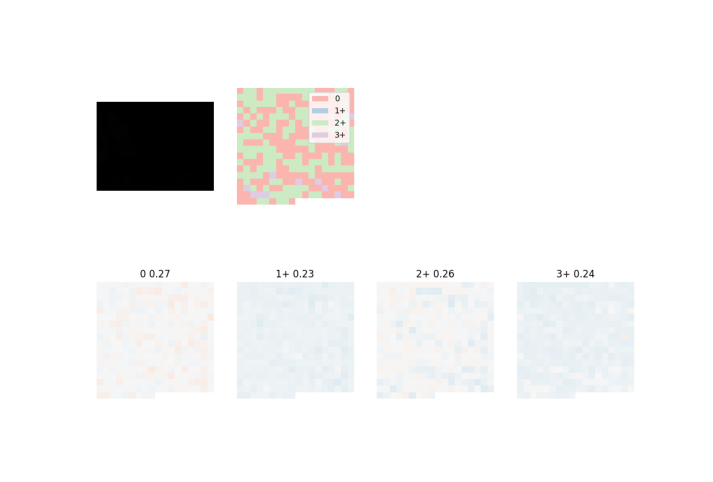

In [17]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# output_dir directly from your config
output_dir = Path(heatmap_config["heatmaps"]["output_dir"])

# find all overview images
overview_images = sorted(
    output_dir.glob("**/plots/overview-*.png"),
    key=lambda p: p.stat().st_mtime,
)

if not overview_images:
    raise FileNotFoundError(
        f"No overview images found under output_dir={output_dir}"
    )

print(f"Found {len(overview_images)} overview image(s)\n")

# display images line by line
for i, overview_path in enumerate(overview_images, start=1):
    print(f"[{i}/{len(overview_images)}] {overview_path}")

    img = Image.open(overview_path)

    # wide but not too tall → good for large images
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
